In [1]:
import tensorflow_datasets as tfds
from utils import * 
import cycle_gan
from discriminator import Discriminator
from discriminator_patchGAN import PatchGAN
from generator import *
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

%load_ext autoreload
%autoreload 2
import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
builder = tfds.ImageFolder('datasets/blue2red/')
# print(builder.info)
train_summers = builder.as_dataset(split="trainA", as_supervised=True)
train_winters = builder.as_dataset(split="trainB", as_supervised=True)
test_summers = builder.as_dataset(split="testA", as_supervised=True)
test_winters = builder.as_dataset(split="testB", as_supervised=True)
# tfds.show_examples(ds, builder.info)

In [3]:
builder = tfds.ImageFolder('datasets/blue2red/')
# print(builder.info)
train_summers = builder.as_dataset(split="trainA", as_supervised=True)
train_winters = builder.as_dataset(split="trainB", as_supervised=True)
test_summers = builder.as_dataset(split="testA", as_supervised=True)
test_winters = builder.as_dataset(split="testB", as_supervised=True)
# tfds.show_examples(ds, builder.info)

In [4]:
# dataset, metadata = tfds.load(
#     "cycle_gan/summer2winter_yosemite", with_info=True, as_supervised=True
# )

# train_summers, train_winters = dataset["trainA"], dataset["trainB"]
# test_summers, test_winters = dataset["testA"], dataset["testB"]

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [6]:
train_summers = (
    train_summers.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

train_winters = (
    train_winters.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

test_summers = (
    test_summers.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

test_winters = (
    test_winters.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

In [26]:
sample_summer = next(iter(train_summers))
sample_winter = next(iter(train_winters))

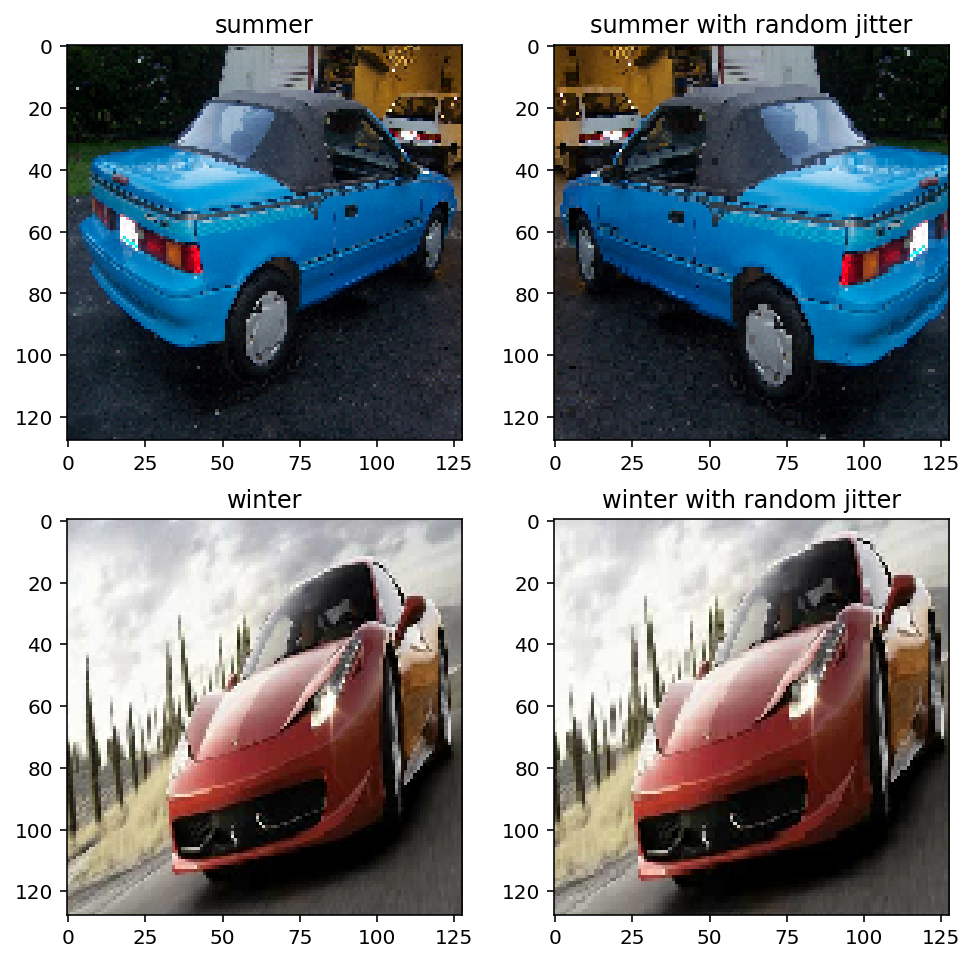

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('summer')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(222)
plt.title('summer with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

plt.subplot(223)
plt.title('winter')
plt.imshow(sample_winter[0] * 0.5 + 0.5)

plt.subplot(224)
plt.title('winter with random jitter')
plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5)

In [28]:
OUTPUT_CHANNELS = 3
IMG_DIM = getImageSize()
FILTERS = 48 # good results with 32

G = Generator(FILTERS, IMG_DIM, name="G")
F = Generator(FILTERS, IMG_DIM, name="F")

D_x = PatchGAN(FILTERS, IMG_DIM, name="D_x")
D_y = PatchGAN(FILTERS, IMG_DIM, name="D_y")

cyclegan_model = cycle_gan.CycleGAN(G, F, D_x, D_y, paper_generator_loss=True)
cyclegan_model.compile(0.0002, 0.5)

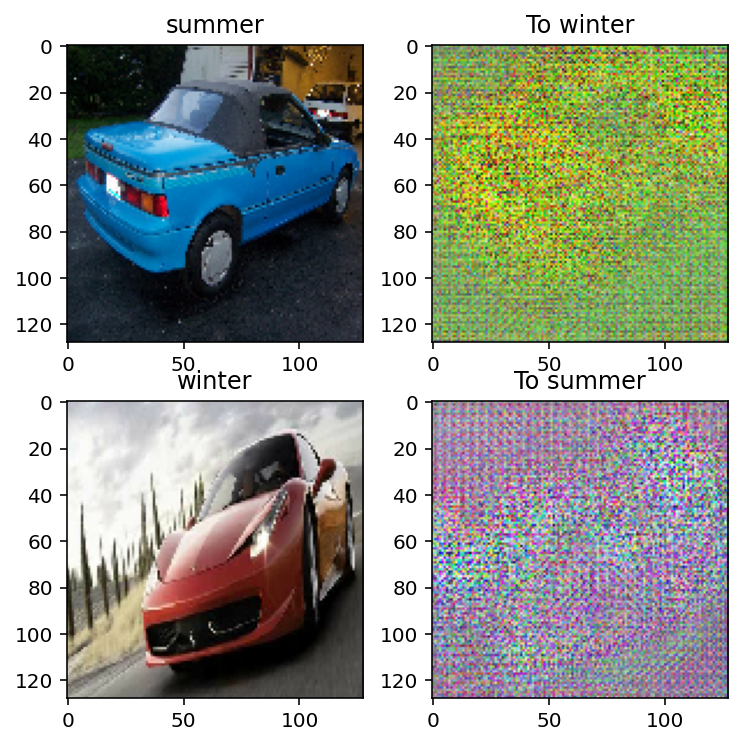

In [29]:
to_winter = G(sample_summer)
to_summer = F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(6, 6))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

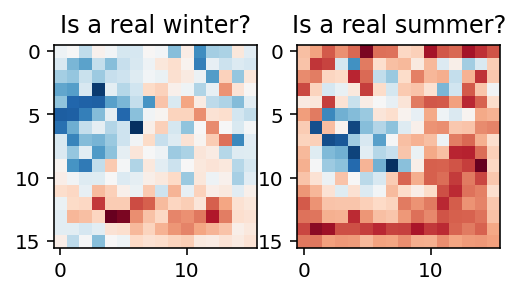

In [30]:
plt.figure(figsize=(4, 4))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(D_y(sample_winter)[0, ..., -1], cmap='RdBu_r')
# plt.imshow((D_y(sample_winter).numpy() + 1) / 2, cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(D_x(sample_summer)[0, ..., -1], cmap='RdBu_r')
# plt.imshow((D_x(sample_summer).numpy() + 1) / 2, cmap='RdBu_r')

plt.show()

In [12]:
# checkpoint_path = "./checkpoints/train"

# ckpt = tf.train.Checkpoint(
#     G=G,
#     F=F,
#     D_x=D_x,
#     D_y=D_y,
# )

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Latest checkpoint restored!!")

In [31]:
cyclegan_model.fit(tf.data.Dataset.zip((train_summers, train_winters)), batch_size=1, epochs=100)

Epoch 1/20
243/243 [==============================] - 103s 192ms/step - G_loss: 0.5914 - F_loss: 0.6760 - D_y_loss: 0.5121 - D_x_loss: 0.5429
Epoch 2/20
243/243 [==============================] - 48s 193ms/step - G_loss: 0.3606 - F_loss: 0.3650 - D_y_loss: 0.2685 - D_x_loss: 0.2713
Epoch 3/20
243/243 [==============================] - 48s 193ms/step - G_loss: 0.3323 - F_loss: 0.3360 - D_y_loss: 0.2652 - D_x_loss: 0.2619
Epoch 4/20
243/243 [==============================] - 48s 192ms/step - G_loss: 0.3361 - F_loss: 0.3381 - D_y_loss: 0.2580 - D_x_loss: 0.2611
Epoch 5/20
243/243 [==============================] - 48s 194ms/step - G_loss: 0.3321 - F_loss: 0.3498 - D_y_loss: 0.2545 - D_x_loss: 0.2489
Epoch 6/20
243/243 [==============================] - 48s 194ms/step - G_loss: 0.3555 - F_loss: 0.3886 - D_y_loss: 0.2444 - D_x_loss: 0.2331
Epoch 7/20
243/243 [==============================] - 48s 194ms/step - G_loss: 0.3884 - F_loss: 0.4626 - D_y_loss: 0.2345 - D_x_loss: 0.2138
Epoch 8/20
2

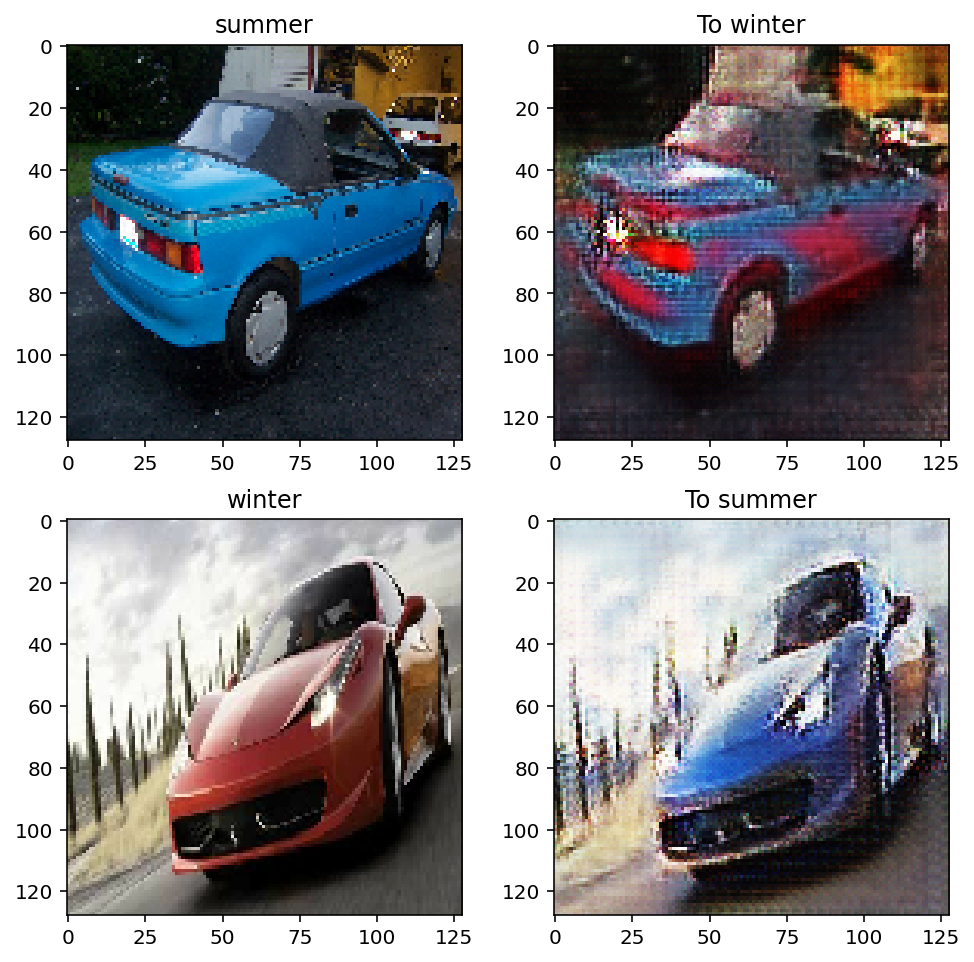

In [32]:
# 2 PatchGANs, 48 features, paper_generator_loss=True
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

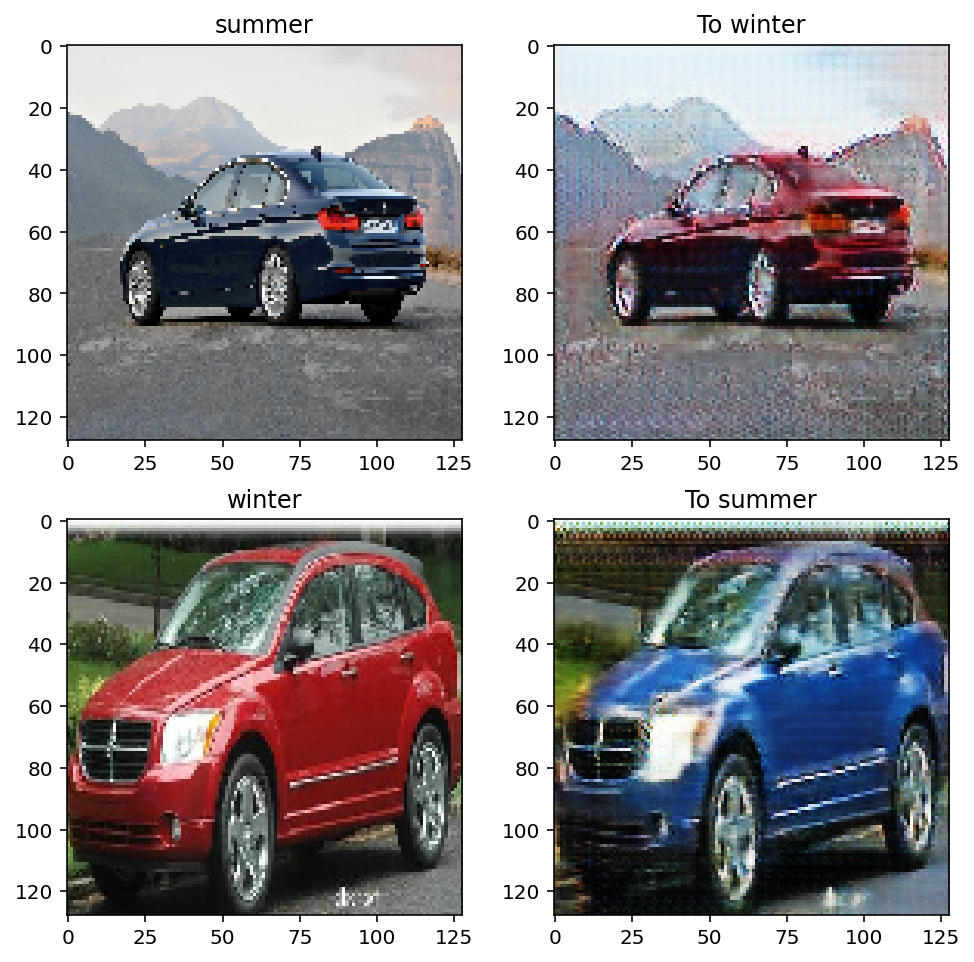

In [17]:
# 2 PatchGANs, 64 features, paper_generator_loss=False
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

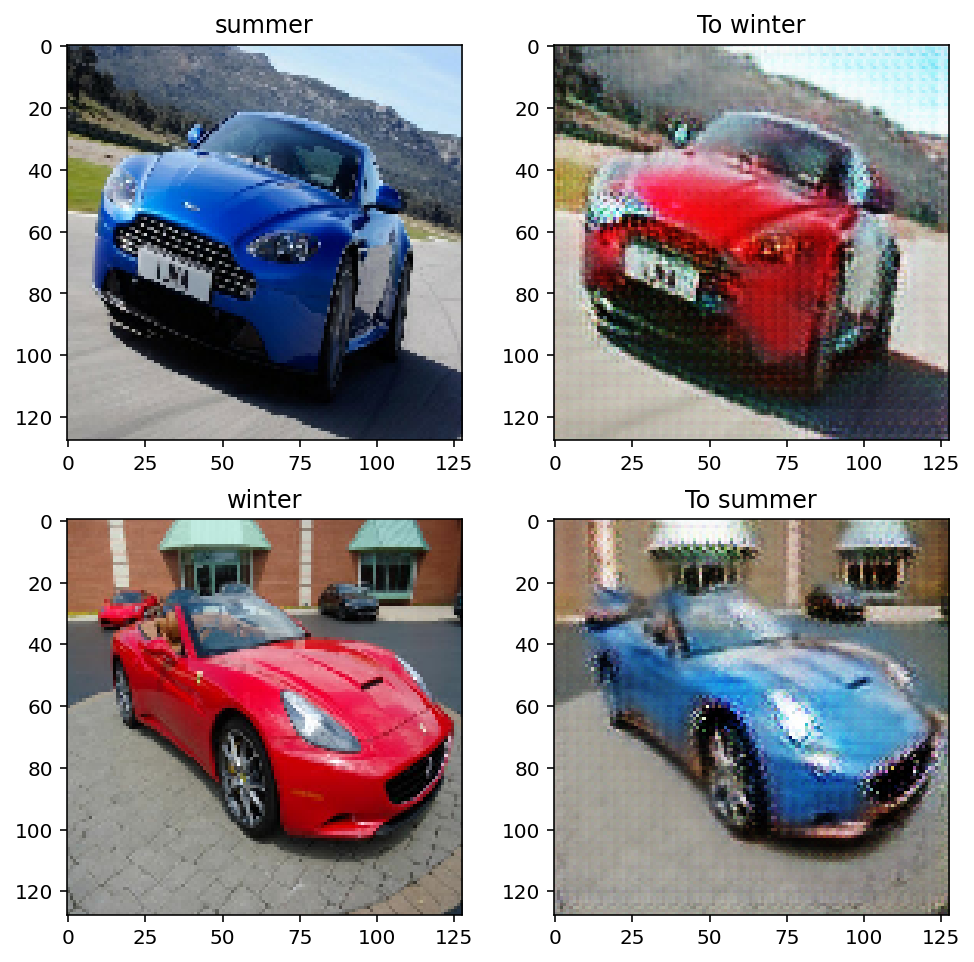

In [25]:
# paper generator loss, 64 features, patchgan
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

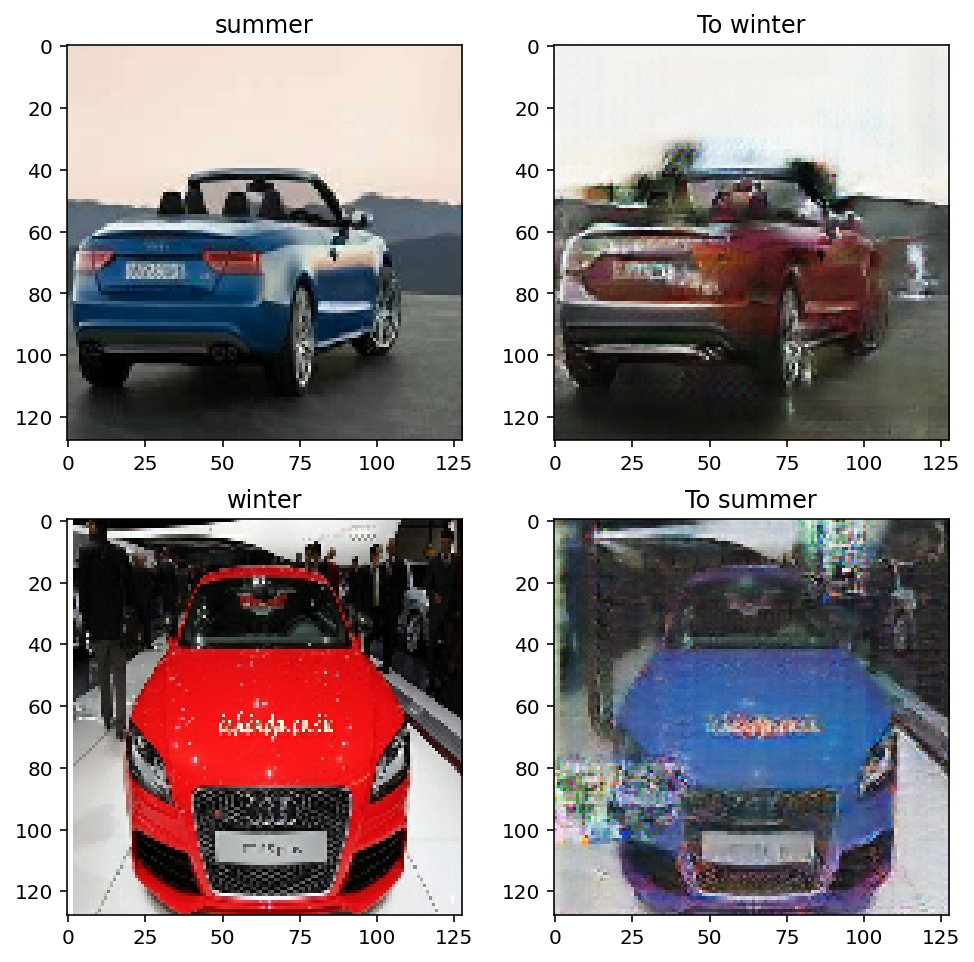

In [32]:
# PatchGAN with 32 initial features/filters

to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

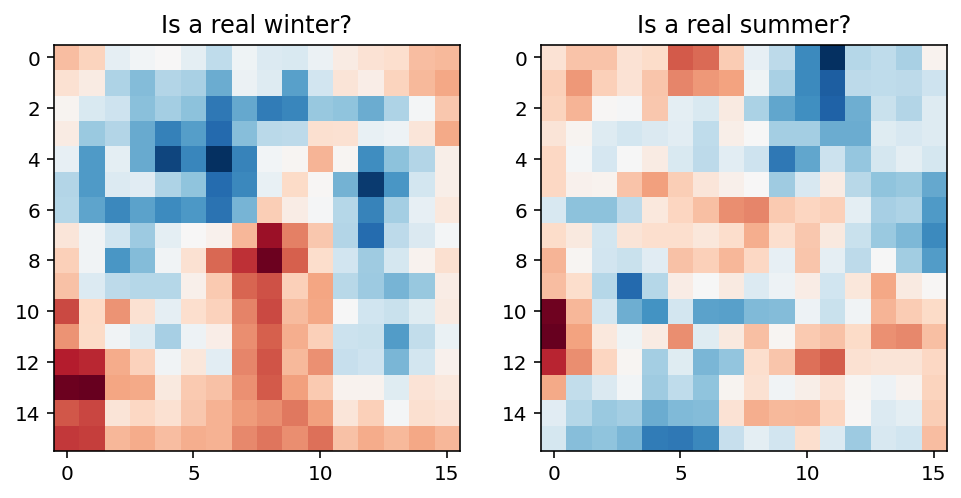

In [37]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(cyclegan_model.D_y(to_winter)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(cyclegan_model.D_x(to_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

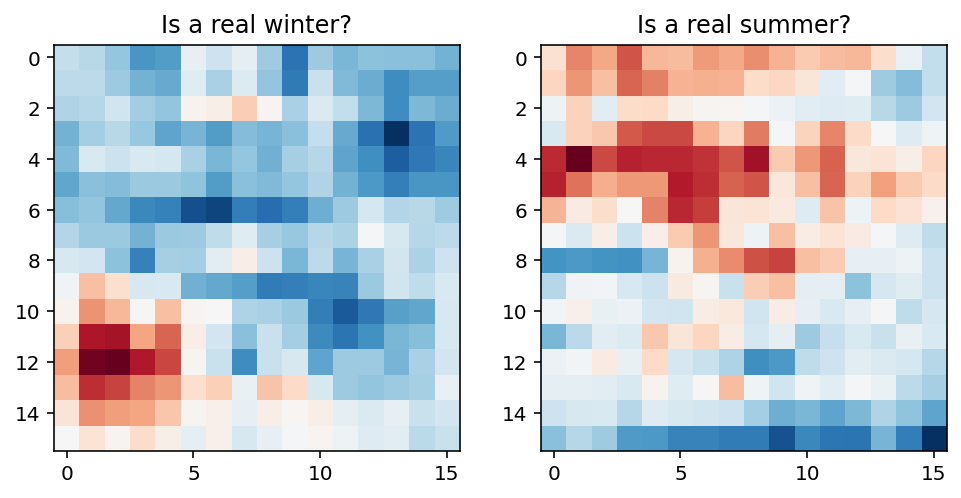

In [36]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(cyclegan_model.D_y(sample_winter)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(cyclegan_model.D_x(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [30]:
ckpt_manager.save()

'./checkpoints/train/ckpt-2'

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_summers, train_winters)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_summer) so that the progress of the model
    # is clearly visible.
    generate_images(G, sample_summer)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))

    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time() - start))

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.

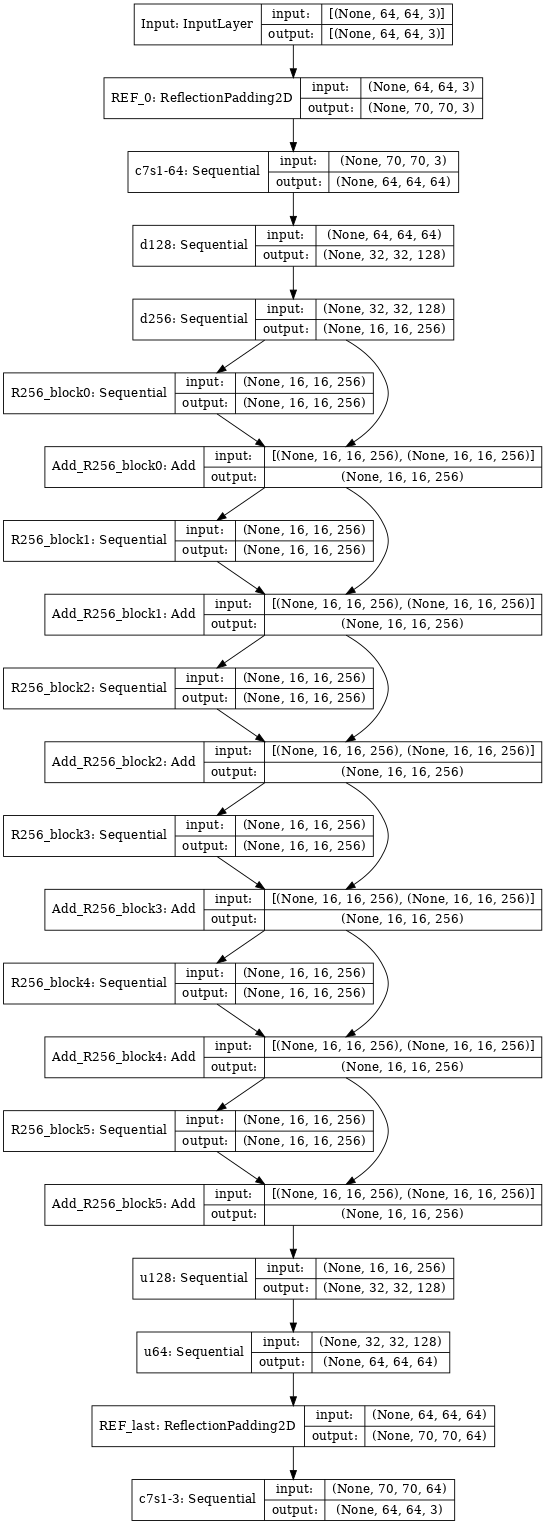

In [11]:
tf.keras.utils.plot_model(
    G, to_file="G.png", show_shapes=True, dpi=64, expand_nested=False
)

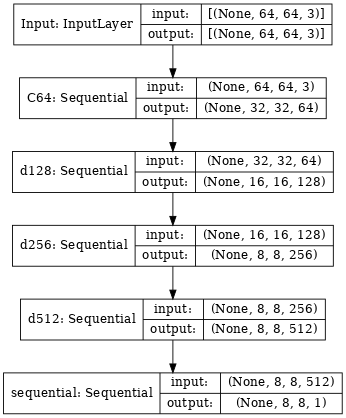

In [15]:
tf.keras.utils.plot_model(
    D_x, to_file="D_x.png", show_shapes=True, dpi=64, expand_nested=False
)

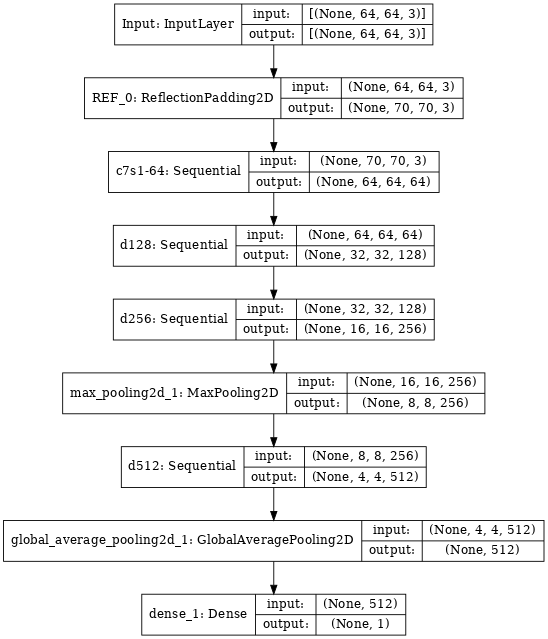

In [10]:
tf.keras.utils.plot_model(
    D_y, to_file="D_y.png", show_shapes=True, dpi=64, expand_nested=False
)